In [1]:
from sys import call_tracing
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import OPTICS, DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
import umap
import mpl_toolkits.mplot3d.axes3d as p3
import os

In [2]:
win_size = 10
use_log = True
use_std = True
# ignore the first day
ignored = 1440

# group_func = 'mean'
group_func = 'mean_and_median'

# umap n_neighbors argument
nn = 50

reducers = {
    'pca': PCA(n_components=3),
    # 'umap': umap.UMAP(n_components=3, metric='cosine', n_neighbors=5, random_state=5566),
    'umap': umap.UMAP(n_components=3, metric='cosine', n_neighbors=nn, random_state=5566),
    # 'umap': umap.UMAP(n_components=3, n_neighbors=15, random_state=5566),
}
# reducer_name = 'pca'
reducer_name = 'umap'
reducer = reducers[reducer_name]
# custom_profile = 'nocustom'
custom_profile = 'cosine-nn%d' % nn
profile = '_'.join([reducer_name, 'log' if use_log else 'nolog', group_func, 'std' if use_std else 'nostd', 'ignore%d' % ignored, custom_profile])
print(profile)

umap_log_mean_and_median_std_ignore1440_cosine-nn50


In [44]:
conv_size = 3
txts = [f for f in os.listdir('./aligned') if f.endswith('.txt')]
monitor_cleaned_smooths = []
act_digests = []
act_origs = []
metas = []

#one_meta2 = pd.read_csv('./meta/one_meta2.csv', sep='\t')
one_meta2_test = pd.read_csv('./meta/one_meta2_test.csv', sep='\t')
for txt in txts:

    # try:
    #     meta = pd.read_csv('./meta/%s' % txt, sep='\t')
    # except:
    #     continue

    meta = one_meta2_test[one_meta2_test.File_Name == os.path.splitext(txt)[0]]
    #meta = one_meta2[one_meta2.File_Name == os.path.splitext(txt)[0]]
    if len(meta) == 0:
        print(txt)
        continue

    monitor = pd.read_csv('./aligned/%s' % txt, sep='\t', header=None)
    monitor = monitor.rename({1:'date', 2:'time'}, axis=1)
    monitor_cleaned = pd.concat([monitor.iloc[:,1:3], monitor.iloc[:,10:]], axis=1)
    monitor_cleaned = monitor_cleaned.iloc[ignored:,:]
    
    #### light dark filter implementation
    #hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned.time], dtype=int)
    #monitor_cleaned['h'] = hms[:,0]
    
    # light
    #monitor_cleaned = monitor_cleaned[(monitor_cleaned.h >= 5) & (monitor_cleaned.h <= 19)].iloc[:,:-1]
    
    # dark 
    #monitor_cleaned = monitor_cleaned[(monitor_cleaned.h <= 5) | (monitor_cleaned.h >= 19)].iloc[:,:-1]
    ####
    
    # monitor_cleaned_smooth = monitor_cleaned.iloc[:,2:].apply(np.convolve, v=np.array([1,1,1,1,1]), mode='valid')
    monitor_cleaned_smooth = monitor_cleaned.iloc[:,2:].apply(np.convolve, v=np.ones(conv_size), mode='valid')
    
    if use_log:
        monitor_cleaned_smooth = np.log(monitor_cleaned_smooth + 1)

    monitor_cleaned_smooth = pd.concat([monitor_cleaned.iloc[(conv_size-1):,:2].reset_index(drop=True), monitor_cleaned_smooth], axis=1)

    hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned_smooth.time], dtype=int)
    monitor_cleaned_smooth['h'] = hms[:,0]
    monitor_cleaned_smooth['mNcell'] = hms[:,1] // win_size
    #monitor_cleaned_smooth = monitor_cleaned_smooth[monitor_cleaned_smooth.h.isin([18,19,20,21,22,23,0,1,2,3,4,5])]
    #monitor_cleaned_smooth['m'] = hms[:,1]
    
    if group_func == 'mean':
        act_digest = pd.concat([monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T, monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T], axis=1)
    else:
        # act_digest = pd.concat([monitor_cleaned_smooth.groupby(['h', 'mNcell']).median().T, monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T], axis=1)
        q1 = monitor_cleaned_smooth.groupby(['h', 'mNcell']).apply(pd.DataFrame.quantile, q=.25).T.iloc[:-2]
        q3 = monitor_cleaned_smooth.groupby(['h', 'mNcell']).apply(pd.DataFrame.quantile, q=.75).T.iloc[:-2]

        monitor_cleaned_smooth_min = monitor_cleaned_smooth.groupby(['h', 'mNcell']).min().T.iloc[2:]
        monitor_cleaned_smooth_max = monitor_cleaned_smooth.groupby(['h', 'mNcell']).max().T.iloc[2:]
        IQR = q3 - q1
        monitor_cleaned_smooth_whisker_min = q1 - 1.5 * IQR
        monitor_cleaned_smooth_whisker_max = q3 + 1.5 * IQR
        
        whisker_min_oob = (monitor_cleaned_smooth_whisker_min < monitor_cleaned_smooth_min)
        whisker_max_oob = (monitor_cleaned_smooth_whisker_max > monitor_cleaned_smooth_max)
        monitor_cleaned_smooth_whisker_min[whisker_min_oob] = monitor_cleaned_smooth_min[whisker_min_oob]
        monitor_cleaned_smooth_whisker_max[whisker_max_oob] = monitor_cleaned_smooth_max[whisker_max_oob]
        
        act_digest = pd.concat([
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T, 
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T,
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).median().T, 
            q1,
            q3,
            monitor_cleaned_smooth_whisker_min,
            monitor_cleaned_smooth_whisker_max,
            ], axis=1)
    
    act_orig = monitor_cleaned_smooth.iloc[:,2:34].T
    #act_digest = monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T / monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T
    #act_digest = monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T
    act_digests.append(act_digest)
    act_origs.append(act_orig)

    metas.append(meta)
    monitor_cleaned_smooths.append(monitor_cleaned_smooth)

meta_union = pd.concat(metas).reset_index(drop=True)
np.sum(meta_union.Instar.isna())
act_digests_npy = np.concatenate(act_digests)
act_origs_npy = np.concatenate(act_origs)
monitor_cleaned_smooths_union = pd.concat(monitor_cleaned_smooths).reset_index(drop=True)

In [45]:
# filter out BF
filter_no_bf = (meta_union['Source'] == 'MF') | (meta_union['Source'] == 'WL') | (meta_union['Source'] == 'OK') | (meta_union['Source'] == 'SC')
meta_filter = meta_union[filter_no_bf]
act_filter = act_digests_npy[filter_no_bf]
#act_filter = act_origs_npy[filter_no_bf]
#act_filter.shape

In [5]:
meta_filter.shape

(296, 28)

In [ ]:
meta_filter

In [46]:
# 3D scatter plot
def scatter3d(data3d, color_map=None, azimuth=-74, elevation=54, figsize=(10, 10)):

    fig = plt.figure(figsize=figsize)
    ax = p3.Axes3D(fig)
    ax.view_init(elevation, azimuth)

    if color_map is None:
        ax.scatter(data3d[:,0], data3d[:,1], data3d[:,2],
                    s=30, edgecolor='k')
    else:
        ax.scatter(data3d[:,0], data3d[:,1], data3d[:,2],
                    color=plt.cm.jet(color_map),
                    s=30, edgecolor='k')
    return ax

def stdscaler (X, use_std=True):
    if use_std:
        return StandardScaler().fit_transform(X)
    else:
        return X

In [82]:
act_filter_transformed

array([[-0.65672267, -0.65347474, -0.64009962, ..., -0.53048811,
        -0.48390415, -0.46573318],
       [-0.65672267, -0.65347474, -0.64009962, ..., -0.53048811,
        -0.48390415, -0.46573318],
       [-0.65672267,  0.92474987,  0.62031418, ..., -0.53048811,
        -0.48390415, -0.46573318],
       ...,
       [-0.09544637,  2.01459986,  0.7082645 , ...,  0.69173122,
         1.20348435,  1.92803759],
       [-0.65672267, -0.65347474, -0.64009962, ..., -0.53048811,
        -0.48390415, -0.46573318],
       [-0.65672267, -0.65347474, -0.64009962, ..., -0.53048811,
        -0.48390415, -0.46573318]])

In [47]:
reducer = umap.UMAP(n_components=3, metric='cosine', n_neighbors=15, random_state=5566)
#reducer = PCA(n_components=3, random_state=5566)

# try:
#     pwdists = pairwise_distances(dr)
# except:
#act_digests_npy = np.concatenate(act_digests)
#act_digests_npy_transformed = stdscaler(act_digests_npy, use_std)
#dr = reducer.fit_transform(act_digests_npy_transformed)

act_filter_transformed = stdscaler(act_filter, use_std)
dr = reducer.fit_transform(act_filter_transformed)
act_filter_transformed.shape
dr.shape
# reducer.fit(act_digests_npy_transformed)
# reducer.transform(act_digests_npy_transformed)
pwdists = pairwise_distances(dr)

pwdists.shape

(296, 296)

In [ ]:
dr.shape
meta_filter

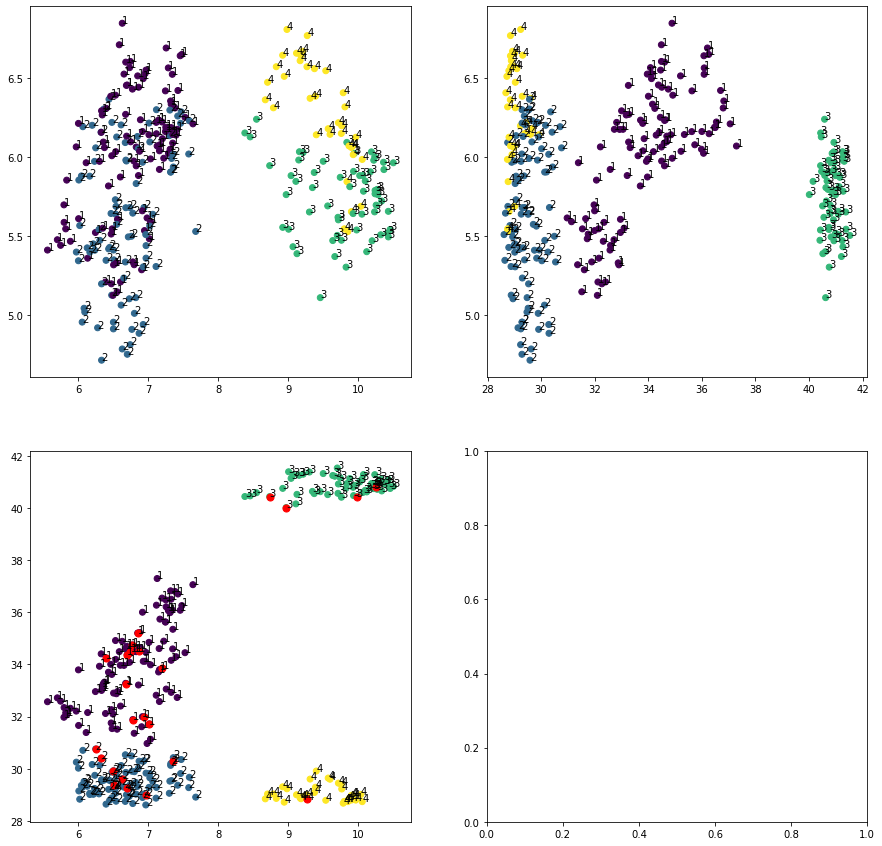

In [52]:
min_samples = 20

shortest_dists_mean = np.take_along_axis(pwdists, np.argsort(pwdists)[:,1:(1+min_samples)], axis=1).mean(axis=1)
shortest_dists_mean_std = shortest_dists_mean.std()
eps = shortest_dists_mean.mean() + 2 * shortest_dists_mean_std

clusterer = DBSCAN(eps=eps, min_samples=min_samples)
group_idxs_ = clusterer.fit_predict(dr) + 1
group_idxs = group_idxs_[group_idxs_ > 0]
dr_wg = dr[group_idxs_ > 0]
gcolor_map = group_idxs / (group_idxs.max() + 1)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0][0].scatter(dr_wg[:,0], dr_wg[:,1], c=gcolor_map)
axs[0][1].scatter(dr_wg[:,2], dr_wg[:,1], c=gcolor_map)
axs[1][0].scatter(dr_wg[:,0], dr_wg[:,2], c=gcolor_map)
for tid in range(dr_wg.shape[0]):
    axs[0][0].text(dr_wg[tid,0], dr_wg[tid,1], group_idxs[tid])
    axs[0][1].text(dr_wg[tid,2], dr_wg[tid,1], group_idxs[tid])
    axs[1][0].text(dr_wg[tid,0], dr_wg[tid,2], group_idxs[tid])
    
dr_MF = dr[meta_filter.Source == 'MF']  
axs[1][0].scatter(dr_MF[:,0], dr_MF[:,2], c='red', s=50)

plt.show()

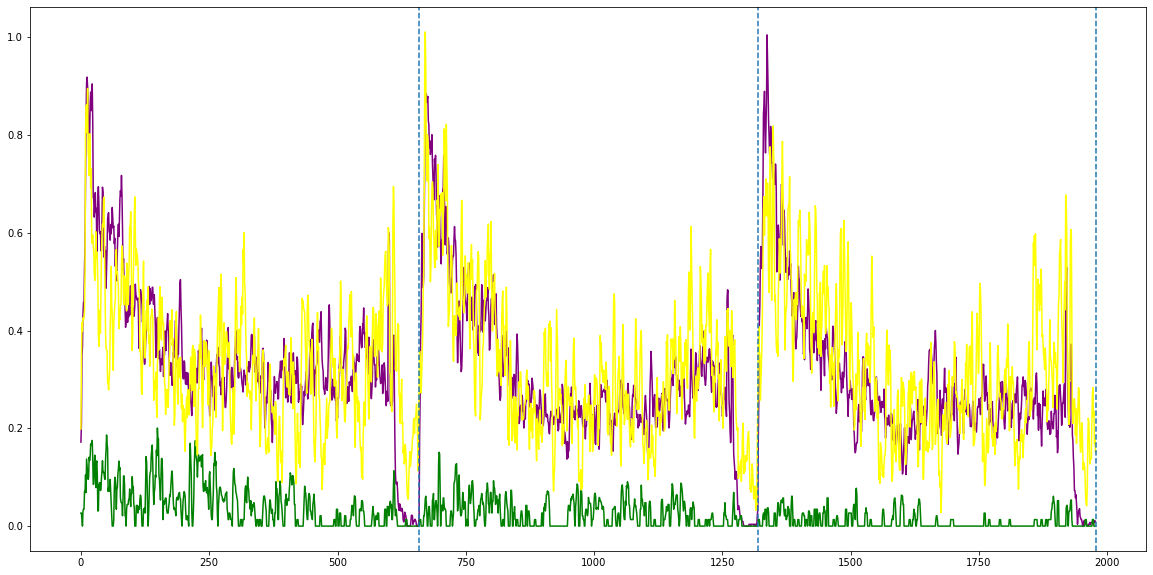

In [18]:
plt.figure(figsize=(20,10))
#plt.plot(act_origs_npy[group_idxs_ == 0].mean(axis=0)) #blue
plt.plot(act_filter[group_idxs_ == 1].mean(axis=0), color='purple')
plt.plot(act_filter[group_idxs_ == 2].mean(axis=0), color='green')
plt.plot(act_filter[group_idxs_ == 3].mean(axis=0), color='yellow')
#plt.plot(act_filter[group_idxs_ == 4].mean(axis=0), color='yellow')
#plt.axvline(659.33, linestyle='--')
#plt.axvline(659.33*2, linestyle='--')
#plt.axvline(659.33*3, linestyle='--')

In [24]:
# using activity patterns to predict source
# meta_union.(Instar, Source, Bury, Gen, Photo).values 
s, y_ = np.unique(meta_filter.Instar.values, return_inverse=True)

In [33]:
y_.shape

(296,)

In [34]:
y_[meta_filter.Instar.isna()] = -1

In [35]:
y = y_[y_ != -1]
len(y)
y.sum()

106

In [54]:
#x_ = meta_union[['Source', 'Gen', 'Sex']].copy()
#x_ = meta_union[['Source']].copy()
x_ = meta_filter[['Source']].copy()
x_['group'] = group_idxs_

#x_ = pd.DataFrame(group_idxs_, columns=['group'])

x = x_[y_ != -1].copy()

#meta_union[x_.group==3]
meta_filter.columns

Index(['ExpID', 'File_Name', 'Env', 'Setup', 'LD_cycle', 'Num', 'ID', 'Nest',
       'Source', 'Location', 'Elevation', 'Gen', 'Sex', 'Photo', 'Circ',
       'Subj_activity', 'Act_index', 'Breeding_nest', 'Start_Date', 'End_Date',
       'Soil', 'Bury', 'Eggs', 'Instar', 'Distance', 'Carcass', 'Phenotype',
       'expression'],
      dtype='object')

In [57]:
meta_filter.shape

(296, 28)

### Random forest model

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [55]:
rfc = RandomForestClassifier(random_state=5566, max_depth=5, n_estimators=200, criterion='entropy')

In [56]:
enc = OneHotEncoder(sparse=False).fit(x)
new_x = enc.transform(x)
new_x.shape
x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=.5, random_state=42)
enc.categories_

[array(['MF', 'OK', 'SC', 'WL'], dtype=object), array([0, 1, 2, 3, 4])]

In [57]:
rfc.fit(x_train, y_train)
accuracy_score(y_train, rfc.predict(x_train))
rfc.score(x_test, y_test)
accuracy_score(y_test, rfc.predict(x_test))

0.7628865979381443

In [18]:
np.concatenate(enc.categories_, axis=0)[np.argsort(rfc.feature_importances_)][-5:]

array([0, 1, 2, 4, 3])

### chi-square

In [76]:
from scipy.stats import chisquare
#scipy.stats.chisquare(f_obs, f_exp=None, ddof=0, axis=0)

group_sizes = pd.DataFrame({'gid':group_idxs}).groupby('gid').size().values
# f_exp: array_like, optional 
# (Expected frequencies in each category. By default the categories are assumed to be equally likely.)
f_exp = group_sizes / group_sizes.sum()

# cand_cols = ['Nest', 'Source', 'Elevation', 'Gen', 'Sex', 'Photo', 'Instar']
cand_cols = ['Source']
#cand_cols = ['Sex']
#cand_cols = ['Gen']
# np.array(np.meshgrid(cand_cols, cand_cols)).T.reshape(-1, 2)
biased_chars_all = np.array([])
chi2_all = np.array([])
pvalue_all = np.array([])
char_sample_size_all = np.array([])
cat_col_str_all = np.array([])
for i in range(len(cand_cols)):
    for j in range(i, len(cand_cols)):
        cat_col = list(np.unique([cand_cols[i], cand_cols[j]]))
        
        #meta_filter = pd.concat(metas).reset_index(drop=True)
        #meta_filter = pd.concat(metas).reset_index(drop=True)
        meta_filter_tmp = meta_filter.copy()
        act_digests_npy = np.concatenate(act_digests)

        cat_col_str = '_x_'.join(cat_col)

        print(cat_col_str)
        meta_filter_tmp[cat_col_str] = meta_filter_tmp[cat_col].replace(np.nan, 'NaN').astype(str).apply('_x_'.join, axis=1)

        char_to_group = pd.DataFrame.from_dict({'gid': group_idxs, 'char': meta_filter_tmp[cat_col_str].values[group_idxs_ > 0]}).pivot_table(index='gid', columns='char', aggfunc=len)
        char_to_group = char_to_group.replace(np.nan, 0)

        f_exp_weighted = char_to_group.sum().values * np.repeat(np.expand_dims(f_exp, axis=0), char_to_group.shape[1], axis=0).T
        # pd.concat([char_to_group.reset_index(), pd.DataFrame(f_exp)], axis=1)
        chi2test = chisquare(char_to_group, f_exp=f_exp_weighted)
        
        pvalue_thres_idxs = (chi2test.pvalue < 0.05)
        biased_chars = char_to_group.columns.values[pvalue_thres_idxs]
        biased_chars_all = np.append(biased_chars_all, biased_chars)
        chi2 = chi2test.statistic[pvalue_thres_idxs]
        chi2_all = np.append(chi2_all, chi2)
        pvalue_all = np.append(pvalue_all, chi2test.pvalue[pvalue_thres_idxs])
        char_sample_size_all = np.append(char_sample_size_all, char_to_group.sum()[pvalue_thres_idxs].values)
        cat_col_str_all = np.append(cat_col_str_all, np.repeat(cat_col_str, chi2.shape[0]))
        print(biased_chars)
        # print([d for d in char_to_group.columns.values if d not in biased_chars])

Source
['OK' 'WL']


In [ ]:
meta_filter

In [77]:
print(char_to_group)
print(chi2test)
print(pvalue_thres_idxs)
print(biased_chars_all)
print(chi2_all)
print(pvalue_all)
print(char_sample_size_all)
print(cat_col_str_all)

char  MF  OK  SC  WL
gid                 
1     11  17  19  59
2      8  31  14  36
3      4  28   7  21
4      1   2   4  29
Power_divergenceResult(statistic=array([ 2.1300419 , 21.61879735,  1.42919172, 11.76377012]), pvalue=array([5.45859032e-01, 7.82968205e-05, 6.98706522e-01, 8.23778857e-03]))
[False  True False  True]
['OK' 'WL']
[21.61879735 11.76377012]
[7.82968205e-05 8.23778857e-03]
[ 78. 145.]
['Source' 'Source']
